[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/example_notebooks/uncertainty_estimation.ipynb)

# Overall Uncertainty Estimation
NeuralProphet allows the modelling of overall prediction intervals. We use the standard pinball loss function in the model to estimate different quantiles specified by the user, without any other distributional assumptions. Here, we demonstrate this feature using the peyton manning dataset.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    data_location = "https://raw.githubusercontent.com/ourownstory/neural_prophet/master/"
else:
    data_location = "../"

In [ ]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")
df = pd.read_csv(data_location + "example_data/wp_log_peyton_manning.csv")
df.head(3)

# Basic Functionality
For estimating the 0.25 and 0.75 quantiles, the NeuralProphet object can be created as follows by
specifying the required quantiles (in between (0,1)) in a list. The 0.5 quantile is always modelled by default.
The progression of the PinballLoss values through the training epochs can be seen.

In [23]:
m = NeuralProphet(
    quantiles=[0.75, 0.25]
)
metrics = m.fit(df, freq="D")

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 22
WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.forecaster._lr_range_test) - learning rate range test found optimal lr: 2.31E-01
Epoch[22/22]: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, PinballLoss=0.00745, MAE=0.351, RegLoss=0]


In [24]:
future = m.make_future_dataframe(df, periods=30)
forecast = m.predict(df=future)
forecast

WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")



,ds,y,yhat1 25.0%,yhat1 50.0%,residual1,yhat1 75.0%,trend 50.0%,season_yearly 50.0%,season_weekly 50.0%
0,2016-01-21,None,8.416165,8.624984,NaN,8.892336,7.671874,1.038282,-0.085172
1,2016-01-22,None,8.416963,8.634569,NaN,8.914017,7.671218,1.034899,-0.071548
2,2016-01-23,None,8.188252,8.393700,NaN,8.668387,7.670562,1.028598,-0.305460
3,2016-01-24,None,8.504296,8.723413,NaN,9.054255,7.669907,1.019348,0.034159
4,2016-01-25,None,8.803212,9.046812,NaN,9.447371,7.669250,1.007140,0.370422
5,2016-01-26,None,8.559281,8.766911,NaN,9.078512,7.668594,0.991983,0.106333
6,2016-01-27,None,8.387021,8.593111,NaN,8.881682,7.667939,0.973907,-0.048735
7,2016-01-28,None,8.324930,8.535074,NaN,8.821695,7.667283,0.952963,-0.085172
8,2016-01-29,None,8.307027,8.524297,NaN,8.820486,7.666627,0.929217,-0.071548
9,2016-01-30,None,8.059727,8.263269,NaN,8.551036,7.665972,0.902757,-0.305460


The forecasts df now has columns designated for the different quantiles of the output yhat1. For the
components, only the 50% quantile is shown in the current state of this feature. The uncertainty bands can
be plotted as below.

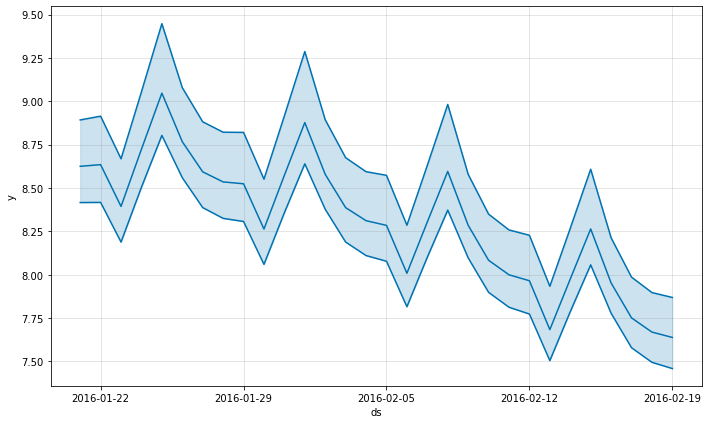

In [25]:
fig_forec = m.plot(forecast)

Similarly the components and parameters can be plotted for the 0.5th quantile.

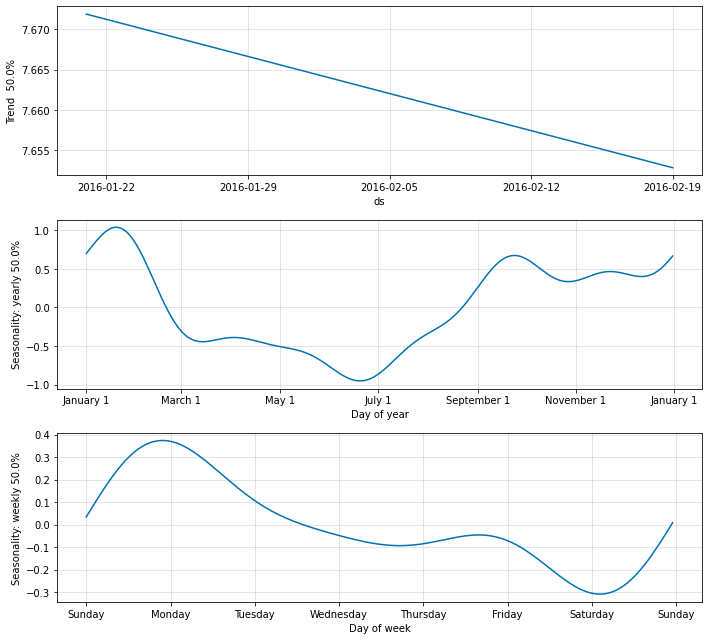

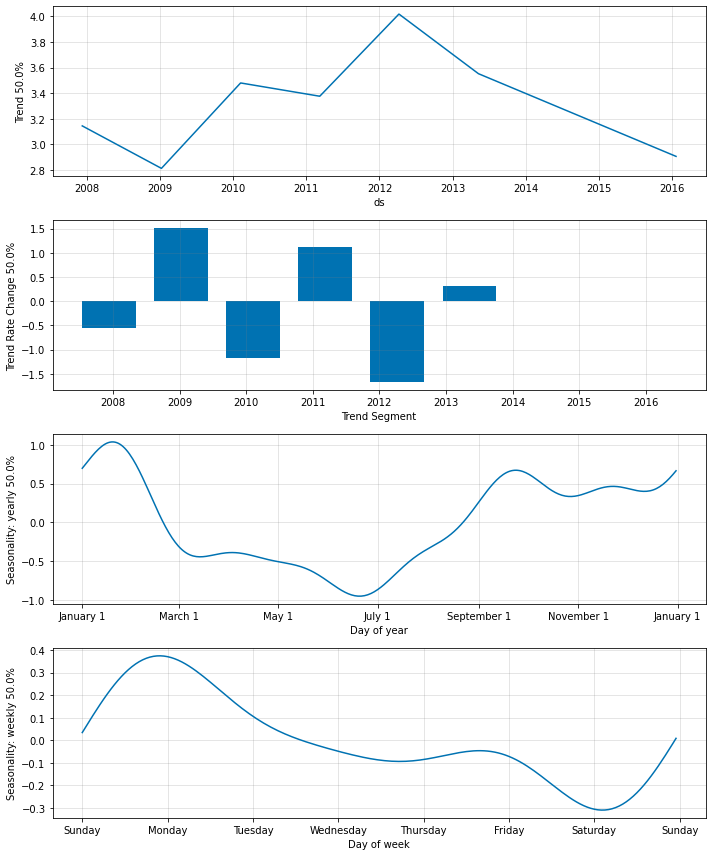

In [26]:
fig_comp = m.plot_components(forecast)
fig_param = m.plot_parameters()

All the other features of the model, such as events, regressors, regularization etc. can be used along with
the quantiles.

In [27]:
playoffs = pd.DataFrame({
    'event': 'playoff',
    'ds': pd.to_datetime([
        '2008-01-13', '2009-01-03', '2010-01-16',
        '2010-01-24', '2010-02-07', '2011-01-08',
        '2013-01-12', '2014-01-12', '2014-01-19',
        '2014-02-02', '2015-01-11', '2016-01-17',
        '2016-01-24', '2016-02-07',
    ]),
})

superbowls = pd.DataFrame({
    'event': 'superbowl',
    'ds': pd.to_datetime([
        '2010-02-07', '2012-02-05', '2014-02-02',
        '2016-02-07',
    ]),
})

events_df = pd.concat((playoffs, superbowls))

# NeuralProphet Object
m = NeuralProphet(
    quantiles=[0.75, 0.25],
    seasonality_reg=1.5,
)

# set the model to expect these events
m = m.add_events(["playoff", "superbowl"], regularization=0.1)

# create the data df with events
history_df = m.create_df_with_events(df, events_df)
metrics = m.fit(history_df, freq="D")

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 22
WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.forecaster._lr_range_test) - learning rate range test found optimal lr: 1.87E-01
Epoch[22/22]: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s, PinballLoss=0.00893, MAE=0.392, RegLoss=0.00126]


WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")



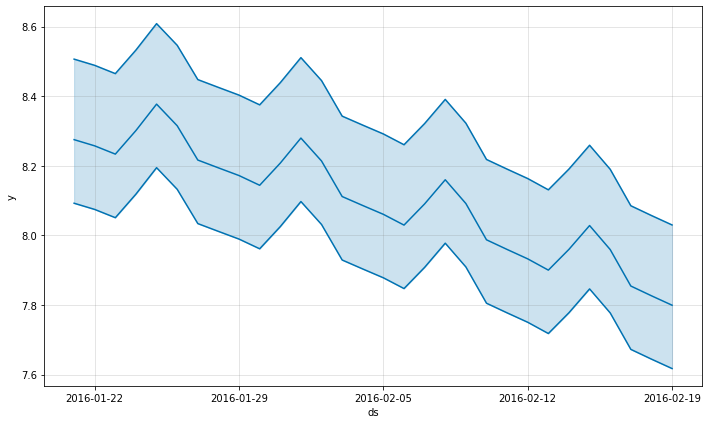

In [28]:
future = m.make_future_dataframe(history_df, events_df, periods=30)
forecast = m.predict(df=future)
fig_forec = m.plot(forecast)

## Different Base Loss Functions
In the standard pinball loss, the base error is just the difference between the actuals and the
predicted. However, in NeuralProphet we provide the user, the capability to define other losses for the
base loss such as `MSE`, `MAE` and `Huber`. This can be done as follows.

In [29]:
m = NeuralProphet(
    loss_func="Huber",
    quantiles=[0.75, 0.25]
)
metrics = m.fit(df, freq="D")

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 22
WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.forecaster._lr_range_test) - learning rate range test found optimal lr: 2.31E-01
Epoch[22/22]: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, PinballLoss=0.00741, MAE=0.353, RegLoss=0]


In [30]:
future = m.make_future_dataframe(df, periods=30)
forecast = m.predict(df=future)

WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")



## With Auto-Regression
Overall uncertainty can be modelled with the AR-Net as well. The only difference is that,
to plot the forecasts, always a forecast step needs to be specified using the `highlight_nth_step_ahead_of_each_forecast` function. The uncertainty bands are plotted
for that particular forecast step, since otherwise the plot can look quite cluttered.

In [31]:
m = NeuralProphet(
    n_lags=5,
    n_forecasts=3,
    quantiles=[0.75, 0.25]
)
metrics = m.fit(df, freq="D")

INFO - (NP.forecaster._handle_missing_data) - 59 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 59 NaN values in column y were auto-imputed.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 21
WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.forecaster._lr_range_test) - learning rate range test found optimal lr: 1.87E-01
Epoch[21/21]: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s, PinballLoss=0.00556, MAE=0.306, RegLoss=0]


In [32]:
future = m.make_future_dataframe(df, periods=3, n_historic_predictions=10)
forecast = m.predict(df=future)

WARNING - (py.warnings._showwarnmsg) - /home/hhew0002/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")



WARNING - (NP.forecaster.plot_last_forecast) - Plotting last forecasts when uncertainty estimation enabled plots the forecasts only for the median quantile.


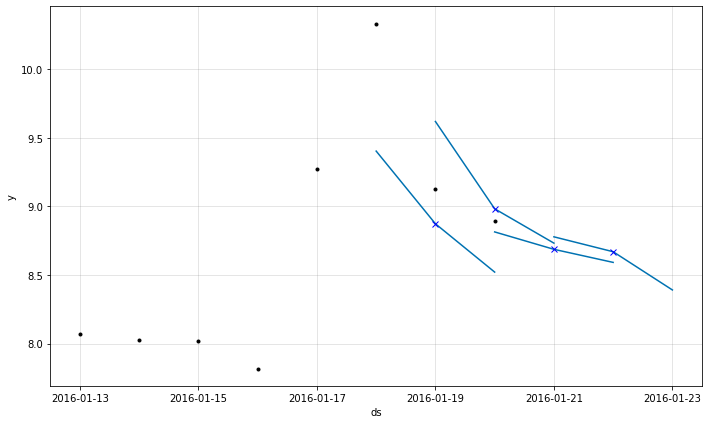

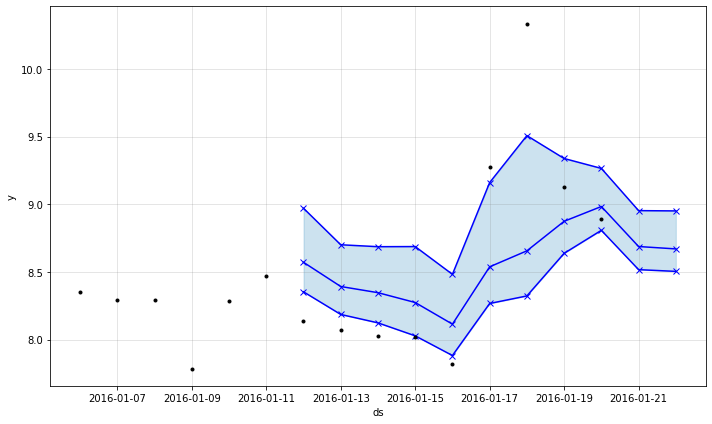

In [33]:
m.highlight_nth_step_ahead_of_each_forecast(2)
fig_last_forec = m.plot_last_forecast(forecast, include_previous_forecasts=3)
fig_forec = m.plot(forecast)